# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install package

In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

plm = "EleutherAI/pythia-410m-deduped"

bos = '<|endoftext|>'
eos = '<|END|>'
pad = '<|pad|>'
sep ='\n\n####\n\n'

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': pad, 'sep_token': sep}

tokenizer = AutoTokenizer.from_pretrained(plm, revision="step3000")
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = 'left'

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

# Training Dataset

In [ ]:
from datasets import load_dataset, Features, Value

# data_path = "/content/drive/MyDrive/AICUP_data/opendid_valid/opendid_set1.tsv"
data_path = "/content/drive/MyDrive/dataset/opendid_valid/new_df_add7.tsv"


dataset = load_dataset("csv", data_files = data_path, delimiter='\t',
                       features = Features({
                              'fid': Value('string'), 'idx': Value('int64'),
                              'content': Value('string'), 'label': Value('string')}),
                       column_names=['fid', 'idx', 'content', 'label'], keep_default_na=False)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
import torch
max_size = len(dataset['train'])
sub_datasets = torch.utils.data.random_split(dataset['train'], [max_size, 0])
print(len(sub_datasets[0]))
for i in range(4): print(sub_datasets[0][i])

82374
{'fid': '227', 'idx': 206, 'content': 'Location:  Hunter Area - BATLOW/ADELONG MULTI PURPOSE SERVICE', 'label': 'DEPARTMENT: Hunter Area\nHOSPITAL: BATLOW/ADELONG MULTI PURPOSE SERVICE'}
{'fid': 'file16635', 'idx': 348, 'content': 'CLINICAL NOTES:', 'label': 'PHI: NULL'}
{'fid': '2009', 'idx': 966, 'content': 'Blocks:  1 to 4 - full LS of anterior body and cervix; 5 to 8 - full LS of anterior body and cervix; 9 - representative section of polypoid lesion on the anterior side; 10 to 14 - full LS of posterior body and cervix;15 - representative section of severe thickened endometrium in the body (posterior portion); 16 - right fallopian tube and fimbrial end; 17 to 19 - right ovary; 20 - representative section of left fallopian tube and fimbrial end; 21 to 23 - left ovary.  ', 'label': 'PHI: NULL'}
{'fid': 'file16348', 'idx': 355, 'content': '- Specimen includes remaining bladder (previous partial cystectomy), urethra, stenosed vagina (previous radiotherapy), colorectum (slightly a

In [ ]:
PAD_IDX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
IGNORED_PAD_IDX = -100
PAD_IDX

50278

In [ ]:
from torch.utils.data import DataLoader
import torch

train_data = list(sub_datasets[0])

def collate_batch(batch):
    texts = [f"{bos} {data['content']} {sep}"+ data['label'].replace('\\n','\n')+f" {eos}" for data in list(batch)] # 範例 prompt
    encoded_seq = tokenizer(texts, padding=True)

    indexed_tks = torch.tensor(encoded_seq['input_ids'])
    attention_mask = torch.tensor(encoded_seq['attention_mask'])
    encoded_label = torch.tensor(encoded_seq['input_ids'])
    encoded_label[encoded_label == tokenizer.pad_token_id] = IGNORED_PAD_IDX

    return indexed_tks, encoded_label, attention_mask

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=False, collate_fn=collate_batch)
titer = iter(train_dataloader)
tks, labels, masks= next(titer)
print(tks.shape)
next(iter(titer))

torch.Size([2, 48])


(tensor([[    0,  2071,  4121,    27, 50276,    18,   281,   577,   428,  2120,
          25169,   273, 13235,  2133,   285, 15380,   895,    28,   608,   281,
            854,   428,  2120, 25169,   273, 13235,  2133,   285, 15380,   895,
             28,   898,   428,  8612,  2593,   273, 36854,  1238, 15411,   327,
            253, 13235,  1930,    28,   884,   281,  1638,   428,  2120, 25169,
            273, 12637,  2133,   285, 15380,   895,    28,  1010,   428,  8612,
           2593,   273,  5460,  5026,  2348, 24360,  9007,   275,   253,  2133,
            313,  5996,  8538,  5110,   558,  1668,   428,   987,  2965, 40113,
           9402,   285,   269,  6785,  3760,   990,    28,  1722,   281,   655,
            428,   987, 43735,    28,  1384,   428,  8612,  2593,   273,  1669,
           2965, 40113,  9402,   285,   269,  6785,  3760,   990,    28,  3127,
            281,  3495,   428,  1669, 43735,    15, 50275, 50279,  6663,    42,
             27,  5812,   209, 50277],
 

In [ ]:
import random
BATCH_SIZE = 3 

class BatchSampler():
    def __init__(self, data, batch_size):
        self.pooled_indices = []
        self.data = data
        self.batch_size = batch_size
        self.len = len(list(data))
    def __iter__(self):
        self.pooled_indices = []
        indices = [(index, len(data["content"])) for index, data in enumerate(self.data)]
        random.shuffle(indices)
        for i in range(0, len(indices), BATCH_SIZE * 100):
            self.pooled_indices.extend(sorted(indices[i:i + BATCH_SIZE * 100], key=lambda x: x[1], reverse=True))
        self.pooled_indices = [x[0] for x in self.pooled_indices]

        for i in range(0, len(self.pooled_indices), BATCH_SIZE):
            yield self.pooled_indices[i:i + BATCH_SIZE]
    def __len__(self):
        return (self.len + self.batch_size - 1) // self.batch_size

bucket_train_dataloader = DataLoader(train_data, batch_sampler=BatchSampler(train_data, BATCH_SIZE),
                                     collate_fn=collate_batch, pin_memory=True)

# Pretrained model

In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(plm,
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    sep_token_id=tokenizer.sep_token_id,
                                    output_hidden_states=False)

model = AutoModelForCausalLM.from_pretrained(plm, revision="step3000", config=config)
model

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 1024)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 1024)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
  

In [ ]:
import torch
from tqdm import tqdm#, tqdm_notebook
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_text(model, tokenizer, seed, n_words=20):
    model = model.to(device)
    model.eval()
    text = tokenizer.encode(seed)
    inputs, past_key_values = torch.tensor([text]), None
    with torch.no_grad():
        for _ in tqdm(range(n_words)):
            out = model(inputs.to(device), past_key_values=past_key_values)
            logits = out.logits
            past_key_values = out.past_key_values
            log_probs = F.softmax(logits[:, -1], dim=-1)
            inputs = torch.multinomial(log_probs, 1)
            text.append(inputs.item())
            if tokenizer.decode(inputs.item()) == eos:
                break


    return tokenizer.decode(text)

sample_text(model, tokenizer, seed=f"{bos} DR AADLAND ABRAHAM {sep}")

100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


'<|endoftext|> DR AADLAND ABRAHAM \n\n####\n\nESA FUN CAPTIT 明 investigations of firearm registration notial 2008.s at INF'

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

EPOCHS = 13 
optimizer = AdamW(model.parameters(),lr=5e-5)

steps = len(bucket_train_dataloader)
total_steps = steps * EPOCHS
print(steps, total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps
)

model.resize_token_embeddings(len(tokenizer))
model.to(device)
print(f'Total numbers of steps: {total_steps}')
model


27458 356954
Total numbers of steps: 356954


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50280, 1024)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
  

# Training

In [ ]:
from tqdm import tqdm,trange

global_step = 0
total_loss = 0
loss_list = []


model.train()
for _ in trange(EPOCHS, desc="Epoch"):
    model.train()
    total_loss = 0

    predictions , true_labels = [], []

    for step, (seqs, labels, masks) in enumerate(bucket_train_dataloader):
        seqs = seqs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        model.zero_grad()
        outputs = model(seqs, labels=labels, attention_mask=masks)
        logits = outputs.logits
        loss = outputs.loss
        loss = loss.mean()
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
    avg_train_loss = total_loss / len(bucket_train_dataloader)
    loss_list.append(avg_train_loss)
    print("Average train loss: {}".format(avg_train_loss))

    torch.save(model.state_dict(), '/content/drive/MyDrive/model/my_model_7.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/model/my_optimizer_7.pth')
    torch.save(scheduler.state_dict(), '/content/drive/MyDrive/model/my_scheduler_7.pth')

Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Average train loss: 1.514401625200126


Epoch:   8%|▊         | 1/13 [47:00<9:24:04, 2820.36s/it]

Average train loss: 1.219165448129494


Epoch:  15%|█▌        | 2/13 [1:33:57<8:36:43, 2818.54s/it]

Average train loss: 1.02283120142527


Epoch:  23%|██▎       | 3/13 [2:20:56<7:49:45, 2818.59s/it]

Average train loss: 0.8602928454424732


Epoch:  31%|███       | 4/13 [3:07:53<7:02:42, 2818.09s/it]

Average train loss: 0.7274829758865321


Epoch:  38%|███▊      | 5/13 [3:54:39<6:15:08, 2813.58s/it]

Average train loss: 0.6331826363840726


Epoch:  46%|████▌     | 6/13 [4:41:19<5:27:42, 2808.96s/it]

Average train loss: 0.5727049736580808


Epoch:  54%|█████▍    | 7/13 [5:28:04<4:40:46, 2807.74s/it]

Average train loss: 0.5319157445678331


Epoch:  62%|██████▏   | 8/13 [6:14:46<3:53:49, 2805.93s/it]

Average train loss: 0.5037434790922458


Epoch:  69%|██████▉   | 9/13 [7:01:33<3:07:05, 2806.28s/it]

Average train loss: 0.4840595921555379


Epoch:  77%|███████▋  | 10/13 [7:48:07<2:20:07, 2802.55s/it]

Average train loss: 0.4689696049109461


Epoch:  85%|████████▍ | 11/13 [8:35:15<1:33:40, 2810.33s/it]

Average train loss: 0.4555846125216336


Epoch:  92%|█████████▏| 12/13 [9:22:42<47:01, 2821.36s/it]  

Average train loss: 0.44226324025771374


Epoch: 100%|██████████| 13/13 [10:10:11<00:00, 2816.30s/it]


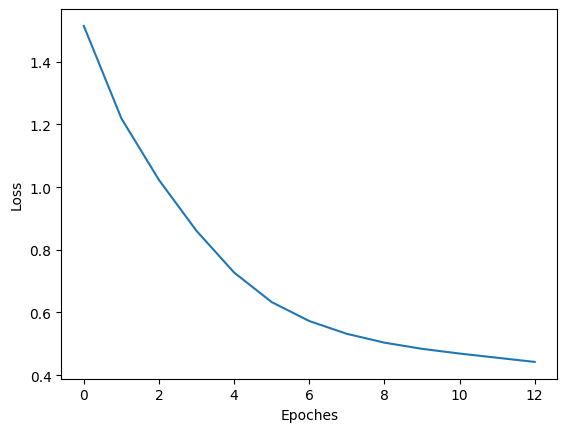

In [ ]:
# loss function image
import matplotlib.pyplot as plt

plt.plot(loss_list)

# 添加標題和標籤
plt.xlabel('Epoches')
plt.ylabel('Loss')

# 顯示圖表
plt.show()

In [ ]:
# 儲存模型

# save_path = '/content/drive/MyDrive/model/my_model_6.pth'
# checkpoint = {
#     'epoch': EPOCHS,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler': scheduler.state_dict()
# }
# torch.save(checkpoint, save_path)